In [1]:
from thesispy.experiments.wandb_client import *
from thesispy.experiments.validation import VALIDATION_NAMES, VALIDATION_ABBRVS
from thesispy.plot_utils import *
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.stats import ttest_ind

In [2]:
ds = get_runs_as_dataset("synthetic_1_fair_comparison_multiresolution")
arrs = ds.aggregate_for_plot(["Optimizer", "MeshSize"], resolution=2)

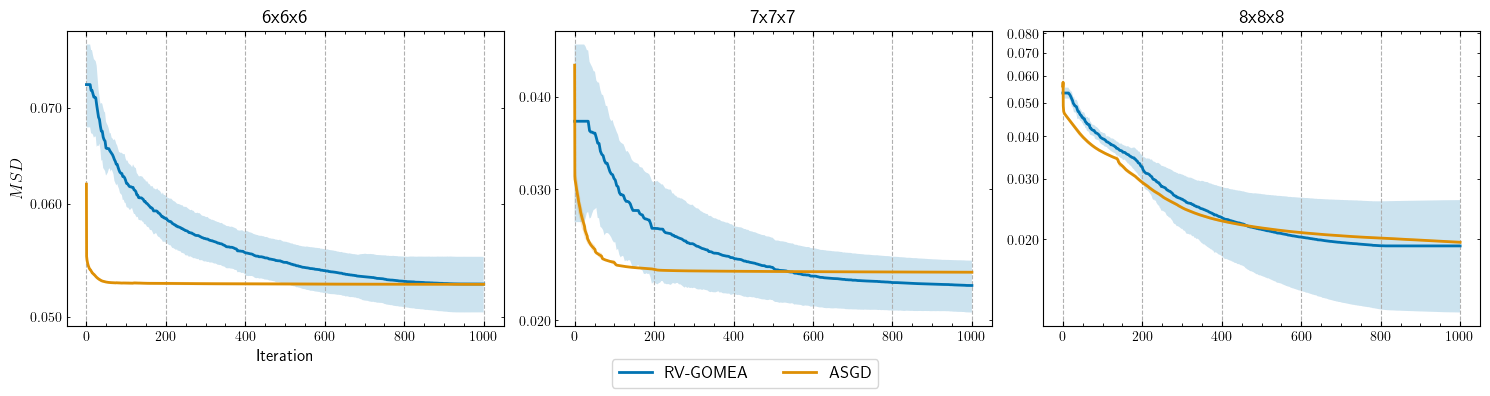

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for optimizer in ["GOMEA", "AdaptiveStochasticGradientDescent"]:
    for i, mesh_size in enumerate([(3, 3, 3), (4, 4, 4), (5, 5, 5)]):
        arr_avg, arr_median, arr_std = arrs[(optimizer, mesh_size)]
        xs = np.linspace(0, 1000, len(arr_median))
        label = "RV-GOMEA" if optimizer == "GOMEA" else "ASGD"
        axes[i].plot(xs, arr_median, label=label)
        axes[i].fill_between(xs, arr_median - arr_std, arr_median + arr_std, alpha=0.2)
        
        # formatting
        axes[i].set_yscale("log")
        axes[i].yaxis.set_major_formatter(formatter)
        axes[i].yaxis.set_minor_formatter(formatter)
        axes[i].set_title(mesh_size_as_str(mesh_size), loc="center", fontsize=14)


axes[0].set_xlabel("Iteration", fontsize=12)
axes[0].set_ylabel("$MSD$", fontsize=12)
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower center", prop={'size': 12})

plt.tight_layout(rect=[0, 0.04, 1, 1])
# plt.savefig("fair_comparison_mr.pdf")

In [30]:
df = ds.aggregate(["Optimizer", "MeshSize"], metrics=VALIDATION_NAMES, val=True)

In [31]:
from tabulate import tabulate

rows = []

for i, metric in enumerate(VALIDATION_NAMES):
    row = []
    row.append(VALIDATION_ABBRVS[i])
    for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
        df_gomea = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "GOMEA")][metric]
        avg_gomea = df_gomea.mean()
        std_gomea = df_gomea.std()

        df_asgd = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "AdaptiveStochasticGradientDescent")][metric]
        avg_asgd = df_asgd.mean()
        std_asgd = df_asgd.std()
        
        gomea_better = avg_gomea < avg_asgd if metric != "dice_similarity" else avg_gomea > avg_asgd
        t_test = ttest_ind(df_gomea, df_asgd, equal_var=False)
        
        if t_test.pvalue >= 0.05:
            row.append(f"{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}")
            row.append(f"{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}")
            continue

        if gomea_better:
            row.append(f"\\textbf{{{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}}}")
            row.append(f"{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}")
        else:
            row.append(f"{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}")
            row.append(f"\\textbf{{{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}}}")

    rows.append(row)

print(tabulate(rows, headers=["RV-GOMEA", "ASGD"]*3, tablefmt="latex_raw"))

\begin{tabular}{lllllll}
\hline
                      & RV-GOMEA                      & ASGD                          & RV-GOMEA             & ASGD                          & RV-GOMEA             & ASGD                          \\
\hline
 $TRE$                & 0.83 ± \num{1.7e-01}          & \textbf{0.44 ± \num{1.4e-03}} & 1.23 ± \num{5.0e-01} & \textbf{0.31 ± \num{9.9e-04}} & 1.92 ± \num{2.5e-01} & \textbf{0.74 ± \num{2.9e-03}} \\
 $WASD$               & \textbf{0.34 ± \num{5.2e-03}} & 0.36 ± \num{8.7e-04}          & 0.31 ± \num{1.8e-02} & \textbf{0.25 ± \num{6.9e-04}} & 0.37 ± \num{7.8e-03} & \textbf{0.34 ± \num{2.0e-03}} \\
 $WHD$                & 0.79 ± \num{3.0e-02}          & \textbf{0.66 ± \num{1.9e-03}} & 0.76 ± \num{9.6e-02} & \textbf{0.42 ± \num{1.2e-03}} & 1.10 ± \num{7.3e-02} & \textbf{1.00 ± \num{2.3e-02}} \\
 $DSC$                & 0.96 ± \num{1.8e-03}          & \textbf{0.97 ± \num{1.2e-16}} & 0.98 ± \num{2.4e-03} & \textbf{0.99 ± \num{0.0e+00}} & 0.99 ± \num{2.9e-03} &

/tmp/ipykernel_46514/633207902.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_test = ttest_ind(df_gomea, df_asgd, equal_var=False)


In [11]:
ds_nomr = get_runs_as_dataset("synthetic_1_fair_comparison")
ds_mr = get_runs_as_dataset("synthetic_1_fair_comparison_multiresolution")

In [12]:
df_nomr = ds_nomr.aggregate(["Optimizer", "MeshSize"], metrics=["metric"], val=True)
df_mr = ds_mr.aggregate(["Optimizer", "MeshSize"], metrics=["metric"], val=True)

In [28]:
rows = []

for optimizer in ["GOMEA", "AdaptiveStochasticGradientDescent"]:
    row = []
    row.append("RV-GOMEA" if optimizer == "GOMEA" else "ASGD")
    for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
        df_nomr_opt = df_nomr.loc[(df_nomr.MeshSize == mesh_size) & (df_nomr.Optimizer == optimizer)]["metric"]
        avg_nomr_opt = df_nomr_opt.mean()
        std_nomr_opt = df_nomr_opt.std()

        df_mr_opt = df_mr.loc[(df_mr.MeshSize == mesh_size) & (df_mr.Optimizer == optimizer)]["metric"]
        avg_mr_opt = df_mr_opt.mean()
        std_mr_opt = df_mr_opt.std() * 2.0

        mr_better = avg_mr_opt < avg_nomr_opt
        t_test = ttest_ind(df_nomr_opt, df_mr_opt, equal_var=False)

        if t_test.pvalue >= 0.05:
            row.append(f"{avg_nomr_opt:.2f} ± \\num{{{std_nomr_opt:.1e}}}".replace("e-0", "e-"))
            row.append(f"{avg_mr_opt:.2f} ± \\num{{{std_mr_opt:.1e}}}".replace("e-0", "e-"))
            continue

        if mr_better:
            row.append(f"{avg_nomr_opt:.2f} ± \\num{{{std_nomr_opt:.1e}}}".replace("e-0", "e-"))
            row.append(f"\\textbf{{{avg_mr_opt:.2f} ± \\num{{{std_mr_opt:.1e}}}}}".replace("e-0", "e-"))

        else:
            row.append(f"\\textbf{{{avg_nomr_opt:.2f} ± \\num{{{std_nomr_opt:.1e}}}}}".replace("e-0", "e-"))
            row.append(f"{avg_mr_opt:.2f} ± \\num{{{std_mr_opt:.1e}}}".replace("e-0", "e-"))
    rows.append(row)

print(tabulate(rows, headers=["c"]*6, tablefmt="latex_raw"))

\begin{tabular}{lllllll}
\hline
          & c                   & c                            & c                   & c                            & c                   & c                            \\
\hline
 RV-GOMEA & 0.12 ± \num{1.9e-3} & \textbf{0.05 ± \num{2.5e-3}} & 0.06 ± \num{1.2e-3} & \textbf{0.02 ± \num{1.9e-3}} & 0.07 ± \num{3.8e-3} & \textbf{0.02 ± \num{7.3e-3}} \\
 ASGD     & 0.13 ± \num{5.9e-6} & \textbf{0.05 ± \num{9.6e-5}} & 0.07 ± \num{2.3e-3} & \textbf{0.02 ± \num{4.3e-6}} & 0.11 ± \num{2.8e-4} & \textbf{0.02 ± \num{1.5e-4}} \\
\hline
\end{tabular}


In [32]:
ttest_results = []
df = ds.aggregate(["Optimizer", "MeshSize"], val=True)

for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
    df_gomea = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "GOMEA")]["metric"].values
    df_asgd = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "AdaptiveStochasticGradientDescent")]["metric"].values
    ttest_results.append(ttest_ind(df_gomea, df_asgd, equal_var=False))
    print(df_gomea.mean(), df_asgd.mean())
    print(df_gomea.std(), df_asgd.std())

print(ttest_results)

0.052701399999999995 0.052690499999999994
0.0011772778941269554 4.577390086064418e-05
0.022511800000000002 0.023208200000000002
0.0008931120646369077 2.0396078054369082e-06
0.0206306 0.0195673
0.003446362000719019 7.24334867309315e-05
[Ttest_indResult(statistic=0.027754968609740728, pvalue=0.9784614853779442), Ttest_indResult(statistic=-2.339230019182031, pvalue=0.044075545342573644), Ttest_indResult(statistic=0.9253803562228188, pvalue=0.3788919906516024)]


In [1]:
from thesispy.experiments.wandb_client import get_run_result
from thesispy.experiments.validation import *

asgd_7 = get_run_result("synthetic_1_fair_comparison_multiresolution", "1qfb8sb3")
gomea_7 = get_run_result("synthetic_1_fair_comparison_multiresolution", "38edej72")

2022-11-22 21:41:54,065 - Validation - INFO - Jacobian min,max: 0.22290517637753793, 6.715382779502547


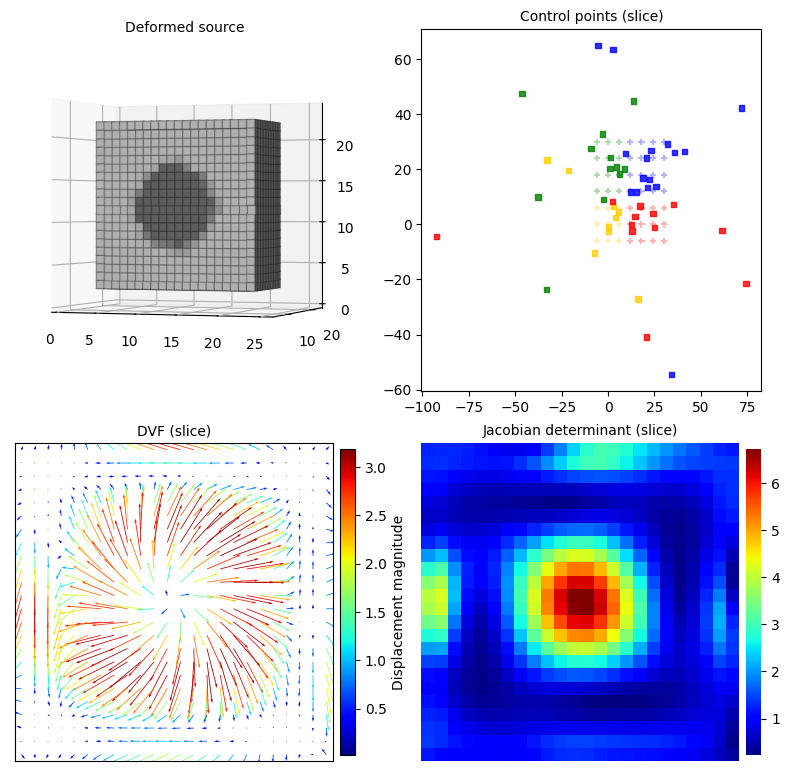

In [2]:
plot_run_result(gomea_7)
plt.savefig("mr_gresult_asgd7.pdf")

2022-11-22 21:41:58,802 - Validation - INFO - Jacobian min,max: 0.17785199953001166, 7.055970083140551


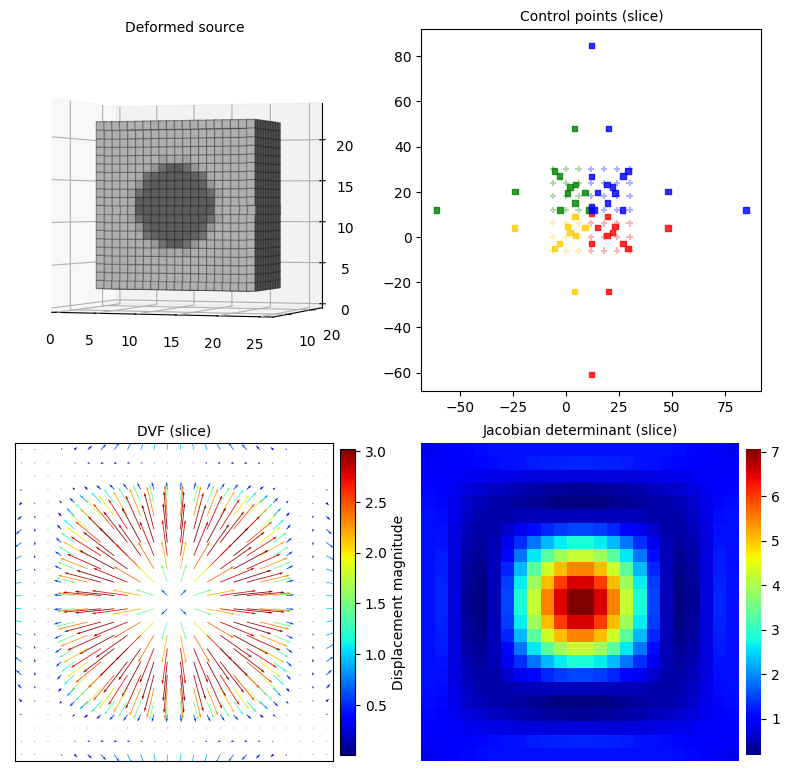

In [3]:
plot_run_result(asgd_7)
plt.savefig("mr_gresult_gomea8.pdf")

In [3]:
df = ds.aggregate(["Optimizer", "MeshSize"], metrics=["missedpixels"], val=True)

<AxesSubplot: xlabel='MeshSize', ylabel='missedpixels'>

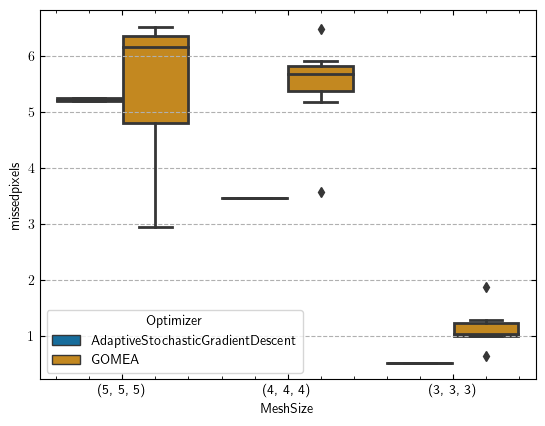

In [5]:
import seaborn as sns

sns.boxplot(df, x="MeshSize", y="missedpixels", hue="Optimizer")

In [7]:
for weight in np.geomspace(0.01, 10, 50):
    print(weight)

0.01
0.011513953993264475
0.013257113655901088
0.015264179671752334
0.017575106248547922
0.020235896477251575
0.023299518105153717
0.02682695795279726
0.030888435964774818
0.03556480306223128
0.040949150623804255
0.04714866363457394
0.054286754393238594
0.06250551925273973
0.07196856730011521
0.08286427728546843
0.09540954763499938
0.10985411419875583
0.12648552168552957
0.14563484775012436
0.16768329368110083
0.19306977288832497
0.22229964825261944
0.2559547922699536
0.29470517025518095
0.3393221771895328
0.3906939937054617
0.44984326689694465
0.517947467923121
0.5963623316594643
0.6866488450043002
0.7906043210907697
0.9102981779915218
1.0481131341546852
1.2067926406393288
1.3894954943731375
1.5998587196060574
1.8420699693267164
2.1209508879201904
2.44205309454865
2.8117686979742307
3.2374575428176433
3.727593720314938
4.291934260128778
4.941713361323833
5.689866029018293
6.551285568595509
7.543120063354615
8.68511373751352
10.0
